# Automatic Segmentation of Basemaps

This notebook demonstrates how to automatically segment BingMaps basemaps, using a FarmVibes.AI workflow that leverages [Segment Anything Model](https://github.com/facebookresearch/segment-anything) (SAM). **We currently only support Unix-based systems (Linux and MacOS) for running this notebook.**

### **Automatic Segmentation** vs. **Prompt-based segmentation**
This is an extension of the [basemap_segmentation notebook](./basemap_segmentation.ipynb). Here we use the automatic segmentation workflow, which allows the segmentation of multiple elements in a raster without requiring user-defined prompts (i.e., points or bounding boxes marking elements of interest). Behind the scenes, it samples several points in a grid throughout the raster and use them as prompts for intermediary segmentation processes. All intermediary masks are, then, filtered and combined into a final set of masks (one for each entity). 

The flexibility of identifying multiple elements in the raster without defining a set of prompts comes with an increase in computing and disk space consumption due to multiple segmentation iterations. Additionally, the output set of masks may not be as refined as the masks obtained from a prompt-based segmentation, because the latter allows a higher control through foreground and background prompts, and consequently yields higher quality masks for individual elements. 


### Notebook Organization

The notebook is divided into the following sections:

1. **Environment setup**: this section provides instructions for obtaining a BingMaps API key, setting up the micromamba environment for FarmVibes.AI, and importing the necessary libraries for the notebook. We also download and export the ONNX files required to run SAM workflows to our cluster.

2. **Workflow setup**: we define a location and time range of interest for our analysis, and build our prompt with multiple points.

3. **Running the workflow**: this section discusses the parameters of the SAM workflow and demonstrates how to run it.

4. **Visualizing the results**: finally, we visualize the results of the workflow.

We run steps 3 and 4 for a few different parameter combinations to demonstrate the effect of the parameters on the results.


## Environment setup

### BingMaps API key
Before running FarmVibes.AI workflows that download BingMaps basemaps, make sure you have an API key for BingMaps. You can get one through the [BingMaps Developer Portal](https://www.bingmapsportal.com/).

Please, make sure you edit the `BINGMAPS_API_KEY` variable in the cell below with your API key:

In [1]:
BING_MAPS_API_KEY = ""

### Importing SAM's ONNX models to the cluster

Before running SAM workflows in FarmVibes.AI, we need to add the model to our cluster. We provide a script that downloads the original weights from the [official repository](https://github.com/facebookresearch/segment-anything) and separately converts the image encoder and prompt encoder + mask decoder to ONNX format. The script also adds the ONNX models to our cluster, allowing them to be used in workflows.

**If you are importing the ONNX files to your cluster for the first time**, make sure the following environment is configured:

```bash
$ micromamba env create -f env_cpu.yaml
$ micromamba activate segment_anything_cpu
```

To run the script, execute the following command **in the repository root**:

```bash
$ python scripts/export_sam_models.py --models < model_types >
```

where `<model_types>` is a list of model types to be exported (`vit_b`, `vit_l`, `vit_h`). For example, to export all three ViT backbones, run:

```bash
$ python scripts/export_sam_models.py --models vit_b vit_l vit_h
```

In this notebook, we will export the `vit_b` model:

In [ ]:
! python ../../scripts/export_sam_models.py --models vit_b

### Imports

**If you already have imported the ONNX files to your cluster**, the standard environment provided in the [README file](../README.md) is sufficient, as most computation will be done within the cluster.

```bash
$ micromamba activate farmvibes-ai
```

Let's start the notebook by importing the necessary libraries:

In [2]:
from datetime import datetime

from notebook_lib.utils import color_autoseg_masks, plot_autoseg_masks
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client

## Workflow setup

FarmVibes.AI has a few workflows related to SAM. In this example, we will use the `farm_ai/segmentation/auto_segment_basemap` workflow, which employs the `data_ingestion/bing/basemap_download_merge` workflow to download a basemap-style image of the input geometry with BingMaps and run the automatic segmentation on top of it.

Before inspecting how the workflow is defined, let's instantiate our client:


In [3]:
client = get_default_vibe_client()

The definition of the `farm_ai/segmentation/auto_segment_basemap` workflow can be inspected with:

In [4]:
client.document_workflow("farm_ai/segmentation/auto_segment_basemap")

Workflow: farm_ai/segmentation/auto_segment_basemap

Description:

Downloads basemap with BingMaps API and runs Segment Anything Model (SAM) automatic segmentation
    over them. The workflow lists and downloads basemaps tiles with BingMaps API, and merges them   
    into a single raster. The raster is then split into chips of 1024x1024 pixels with an overlap   
    defined by `spatial_overlap`. Each chip is processed by SAM's image encoder, and a point grid is
    defined within each chip, with each point being used as a prompt for the segmentation. Each     
    point is used to generate a mask, and the masks are combined using multiple non-maximal         
    suppression steps to generate the final segmentation mask. Before running the workflow, make    
    sure the model has been imported into the cluster by running                                    
    `scripts/export_prompt_segmentation_models.py`. The script will download the desired model      
    weights from SAM repository, export the image encoder and mask decoder to ONNX format, and add  
    them to the cluster. For more information, refer to the [FarmVibes.AI                           
    troubleshooting](https://microsoft.github.io/farmvibes-ai/docfiles/markdown/TROUBLESHOOTING.html
    ) page in the documentation.

Sources:

- user_input (vibe_core.data.core_types.DataVibe): Time range and geometry of interest.

Sinks:

- basemap (vibe_core.data.rasters.Raster): Merged basemap used as input to the segmentation.

- segmentation_mask (vibe_core.data.rasters.CategoricalRaster): Output segmentation masks.

Parameters:

- bingmaps_api_key (default: None): Required BingMaps API key.

- basemap_zoom_level (default: 14): Zoom level of interest, ranging from 0 to 20. For instance, 
    a zoom level of 1 corresponds to a resolution of 78271.52 m/pixel, a zoom level of 10           
    corresponds to 152.9 m/pixel, and a zoom level of 19 corresponds to 0.3 m/pixel. For more       
    information on zoom levels and their corresponding scale and resolution, please refer to the    
    BingMaps API documentation at                                                                   
    https://learn.microsoft.com/en-us/bingmaps/articles/understanding-scale-and-resolution

- model_type (default: vit_b): SAM's image encoder backbone architecture, among 'vit_h',        
    'vit_l', or 'vit_b'. Before running the workflow, make sure the desired model has been exported 
    to the cluster by running `scripts/export_sam_models.py`. For more information, refer to the    
    FarmVibes.AI troubleshooting page in the documentation.

- spatial_overlap (default: 0.5): Percentage of spatial overlap between chips in the range of   
    [0.0, 1.0).

- points_per_side (default: 16): The number of points to be sampled along one side of the chip  
    to be prompts. The total number of points is points_per_side**2.

- n_crop_layers (default: 0): If >0, mask prediction will be run again on crops of the image.   
    Sets the number of layers to run, where each layer has 2**i_layer number of image crops.

- crop_overlap_ratio (default: 0.0): Sets the degree to which crops overlap. In the first crop  
    layer, crops will overlap by this fraction of the chip length. Later layers with more crops     
    scale down this overlap.

- crop_n_points_downscale_factor (default: 1): The number of points-per-side sampled in layer n 
    is scaled down by crop_n_points_downscale_factor**n.

- pred_iou_thresh (default: 0.88): A filtering threshold in [0,1] over the model's predicted    
    mask quality/score.

- stability_score_thresh (default: 0.95): A filtering threshold in [0,1], using the stability of
    the mask under changes to the cutoff used to binarize the model's mask predictions.

- stability_score_offset (default: 1.0): The amount to shift the cutoff when calculated the     
    stability score.

- points_per_batch (default: 16): Number of points to process in a single batch.

- num_workers (default: 0): Number of workers to use for parallel processing.

- in_memory (default: True): Whether to load the whole raster in memory when running            
    predictions. Uses more memory (~4GB/worker) but speeds up inference for fast models.

- chip_nms_thr (default: 0.7): The box IoU cutoff used by non-maximal suppression to filter     
    duplicate masks within a chip.

- mask_nms_thr (default: 0.5): The box IoU cutoff used by non-maximal suppression to filter     
    duplicate masks between different chips.

Tasks:

- basemap_download: Downloads Bing Maps basemap tiles and merges them into a single raster.

- basemap_automatic_segmentation: Runs a Segment Anything Model (SAM) automatic segmentation    
    over BingMaps basemap rasters.

### Understanding the main parameters of the automatic segmentation

The `farm_ai/segmentation/auto_segment_basemap` has a single input, which is the geometry of interest. It will download a BingMaps basemap for the specified region, and segment the raster using the SAM model. The output is a [`CategoricalRaster`](https://microsoft.github.io/farmvibes-ai/docfiles/code/vibe_core_data/rasters.html#vibe_core.data.rasters.CategoricalRaster) with the segmentation results.

The workflow has two tasks (`data_ingestion/bing/basemap_download_merge` and `ml/segment_anything/basemap_automatic_segmentation`). The `basemap_download_merge` task downloads the basemap, which is forwarded to the `basemap_auto_segmentation` task that segments each element and combines the results into a single mask raster.

As for parameters, the main ones related to the segmentation process of the `basemap_auto_segmentation` task are:

- `model_type`: defines the backbone architecture for SAM's image encoder, among `vit_b`, `vit_l`, and `vit_h`. The default value is `vit_b`.
- `spatial_overlap`: the input raster is split into chips of size 1024x1024 pixels. This parameter defines the spatial overlap between chips in the segmentation process. The default value is 0.5, meaning that the chips will overlap by 50%. Increasing this parameter allows the segmentation of elements that may fall in the border of two chips, but also increases computation, as more chips will be processed.
- `points_per_side`: determines the size of the point grid sampled for each chip, i.e. the number of points to be sampled along one side of the chip to be used as prompts. The total number of points in a grid is `points_per_side**2`. The default value is 16, and increasing this parameter allows the model to capture smaller elements within the chip (as we increase the chance of a point being sampled within that element).
- `n_crop_layers`: if greater than 0, the segmentation process will be run on crops of the chip. This parameter sets the number of layers to run, where each layer has `2**i_layer` number of image crops. For example, with `n_crop_layers=0` the segmentation is run solely on each chip. With `n_crop_layers=1`, besides the each chip, the segmentation is also run in 4 smaller crops (2 by 2) per chip, and so on. The masks obtained across all crops are combined. By operating on smaller images as well, this parameter allows the model to capture more details and improve the segmentation quality, at the cost of increased computation. The default value is 0 (i.e., only runs the segmentation on the whole chip).
- `crop_overlap_ratio`: sets the degree to which crops overlap. This is similar to the `spatial_overlap` parameter, but with respect to crops (defined by the `n_crop_layers` parameter). The default value is 0.0.
- `crop_n_points_downscale_factor`: the number of points sampled in each layer is scaled down by this factor. The number of points-per-side sampled in layer `n` is scaled down by `crop_n_points_downscale_factor**n`. The default value is 1 (i.e., no downscaling, the same number of points is sampled in each layer).
- `pred_iou_thresh`: a filtering threshold in the range of [0,1] over the model's predicted mask quality/score. This is used to remove masks which SAM assigns a low quality/confidence score. The default value is 0.88.
- `stability_score_thresh`: a filtering threshold in the range of [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions. This is used to remove masks that vary considerably due to small changes in the binarization threshold. The default value is 0.95.                                            
- `stability_score_offset`: the amount to shift the binarization cutoff when calculating the stability score. The default value is 1.0.
- `points_per_batch`: the number of points to process in a single batch. The default value is 16.

Additionally, there are two parameters related to the filtering and combination of masks:

- `chip_nms_thr`: the box IoU cutoff used by non-maximal suppression to filter duplicate masks within a chip. Decreasing this threshold means that masks in the same chip that share lower IoUs might be filtered out from the final mask. Whereas higher cutoffs allows masks that share higher IoU with other masks to be considered for the output. The default value is 0.7.
- `mask_nms_thr`: the box IoU cutoff used by non-maximal suppression to filter duplicate masks between different chips. This is similar to `chip_nms_thr`, but applied across chips. The default value is 0.5.

## Running the workflow

Let's define a location to download data from. In this example, we select a small region around a defined latitude/longitude.

In [5]:
geom = shpg.Point(74.924041, 17.940487).buffer(0.0025, cap_style=3)

We will start by sampling 8 points per side in each chip, with no spatial overlap between chips:

In [6]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 8,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

Output()

The output of the segmentation is a raster containing a mask with the same size as the input RoI, with each channel corresponding to one identified entity. 

The values of the mask are 0 (background) or 1 (foreground) and we can visualize them by plotting each channel with a different color:

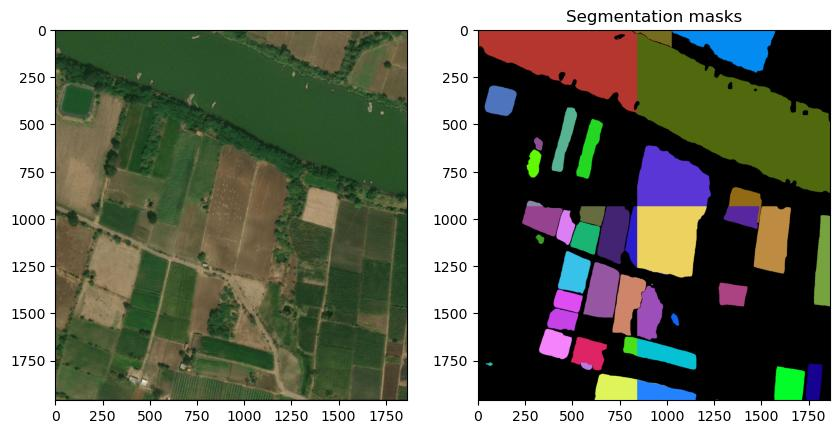

In [7]:
plot_autoseg_masks(
    run.output["basemap"][0],
    {"Segmentation masks": color_autoseg_masks(run.output["segmentation_mask"][0])},
    geom,
)

The workflow captures a few of the fields and the river above the farms, but it still misses some of them or groups different fields together. This happens because SAM is only able to segment entities in which a point of the sampled grid falls. To improve the segmentation, we can increase the number of points sampled in the grid, which will increase the chances of sampling points inside the other elements on the scene.


Let's use `points_per_side = 16`:



Output()

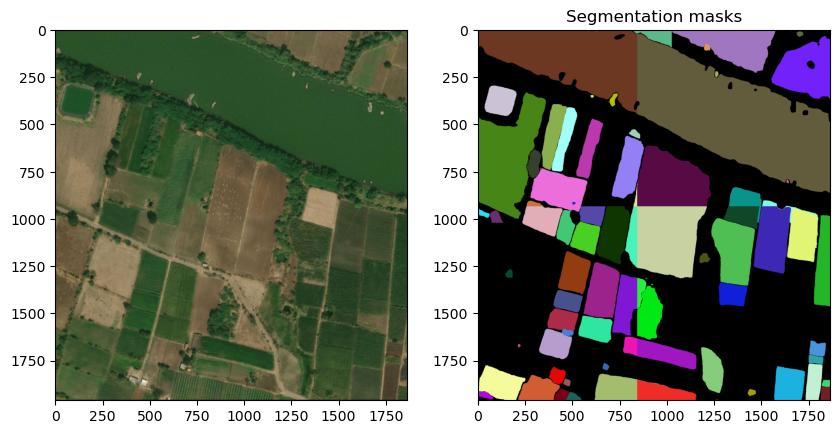

In [8]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 16,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

plot_autoseg_masks(
    run.output["basemap"][0],
    {"Segmentation masks": color_autoseg_masks(run.output["segmentation_mask"][0])},
    geom,
)

This time around, we were able to identify more fields. Let's try with 32 points in the grid:

Output()

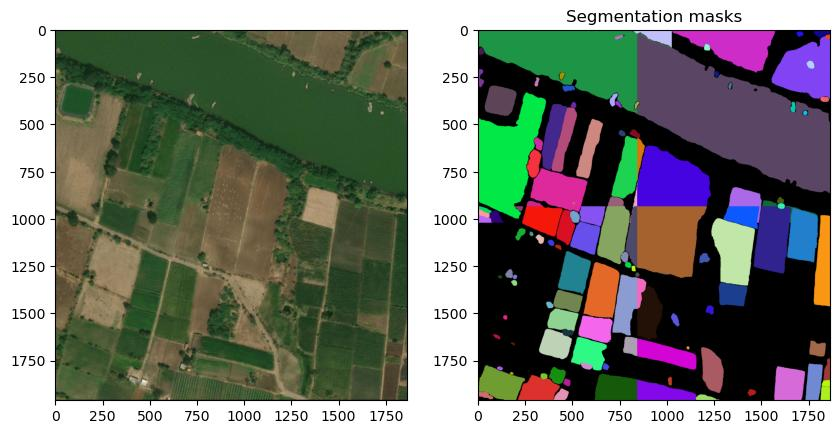

In [9]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 32,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

plot_autoseg_masks(
    run.output["basemap"][0],
    {"Segmentation masks": color_autoseg_masks(run.output["segmentation_mask"][0])},
    geom,
)

Even though we were able to identify a few more fields, jumping from 16 to 32 points in our grid did not improve the segmentation as much as the previous grid size increase. We also see that a pattern into the middle portion of the output mask, a straight line that runs top-to-bottom and left-to-right, splitting the river and some fields in multiple entities.

That happens because each chip is processed independently, and the model is not able to combine masks from different chips. To improve the segmentation, we can increase the spatial overlap between chips, which will allow the model to capture more context around the edges of the chips.

Let's increase `spatial_overlap` to 0.5 and keep `points_per_side = 32`:

Output()

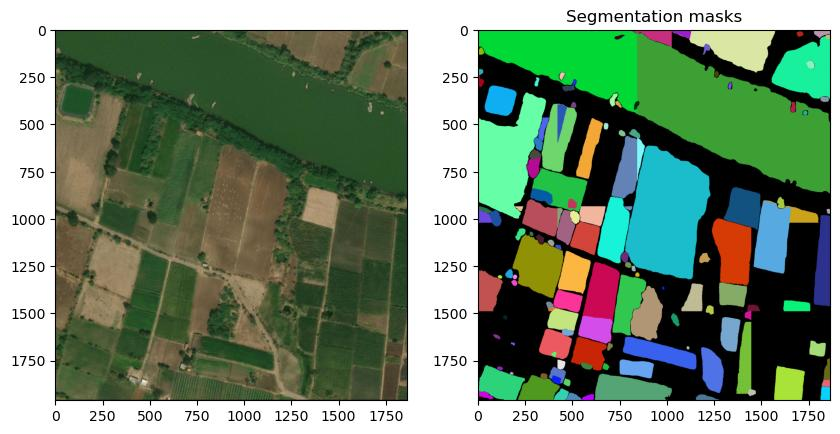

In [10]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 32,
        "spatial_overlap": 0.5,
    },
)
run.monitor()

plot_autoseg_masks(
    run.output["basemap"][0],
    {"Segmentation masks": color_autoseg_masks(run.output["segmentation_mask"][0])},
    geom,
)

With these changes, the output segmentation looks much better. However, we still see a few missing fields on darker/non-activated regions of our mask. This might be due to the filtering steps in the workflow that may remove masks that SAM assigned a low confidence or that overlaped with other masks.

In the next sections, we will explore these and other parameters on a larger region.

## Exploring the workflow parameters on a larger region

For this set of experiments, we will define a geometry that is slightly larger than the previous one:

In [5]:
geom = shpg.Point(74.924041, 17.940487).buffer(0.005, cap_style=3)

And let's run the workflow with the 8 `points_per_side` and no `spatial_overlap`:

Output()

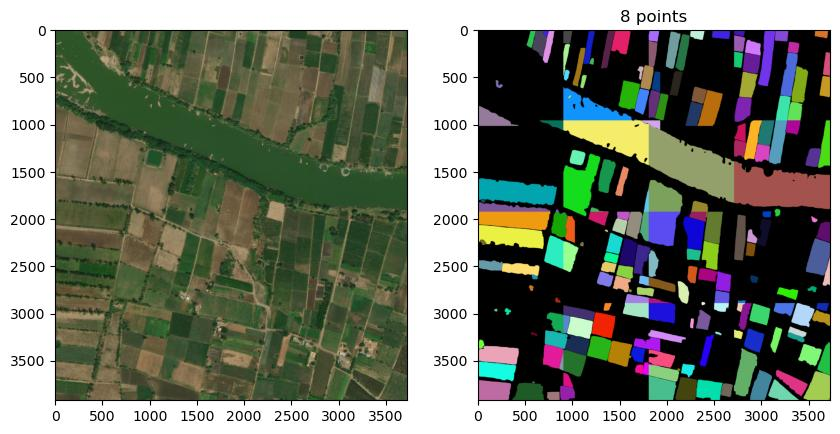

In [6]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 8,
        "spatial_overlap": 0.0,
    },
)
run.monitor()

basemap = run.output["basemap"][0]
seg_raster_8pps = color_autoseg_masks(run.output["segmentation_mask"][0])

plot_autoseg_masks(basemap, {"8 points": seg_raster_8pps}, geom)

Even though the workflow is able to identify several fields, we can see a similar checkboard pattern across the segmentation mask, due to the lack of spatial overlap between chips.

Let's re-run the workflow with an overlap of 0.5:

Output()

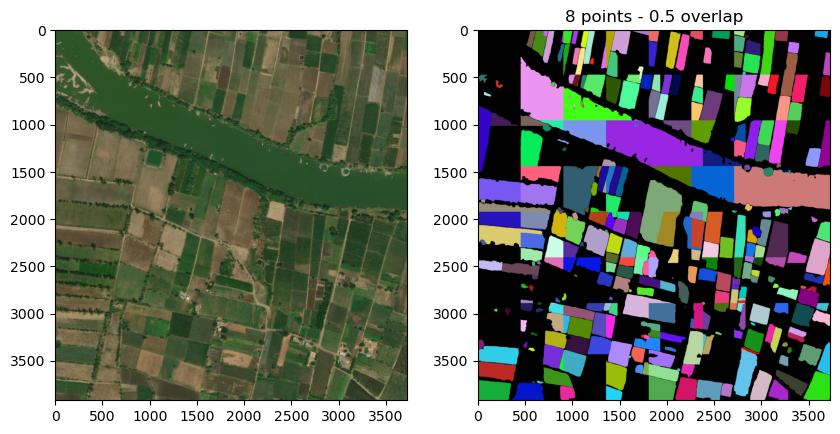

In [7]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 8,
        "spatial_overlap": 0.5,
    },
)
run.monitor()

seg_raster_8pps_half_overlap = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(basemap, {"8 points - 0.5 overlap": seg_raster_8pps_half_overlap}, geom)

The overlap improved the segmentation of individual fields, with only a few being split into different entities. With a field being covered by multiple chips, we increase the chance that the workflow will obtain a segmentation mask that covers the whole field (among several partial masks). We post-process the intermediary masks, filtering out those that overlap considerably with others.  

Despite that, we still see a checkboard pattern across the river in the image. That is a limitation of the automatic segmentation workflow, as it is not able to combine masks from different chips. Because the river spans multiple chips, the intermediary masks will not overlap as much and most of them will be kept in the output segmentation.

The post-process filtering steps in the workflow are tweaked by the `crop_nms_thr` and `mask_nms_thr` parameters. They both represent IoU thresholds used to consider two masks as representing the same entity. While `crop_nms_thr` is used to de-duplicate masks within each chip, `mask_nms_thr` is used to de-duplicate masks across chips.

Below we show the differences in the final mask by changing `mask_nms_thr` from 0.5 (the default value) to 0.3 and 0.15:

Output()

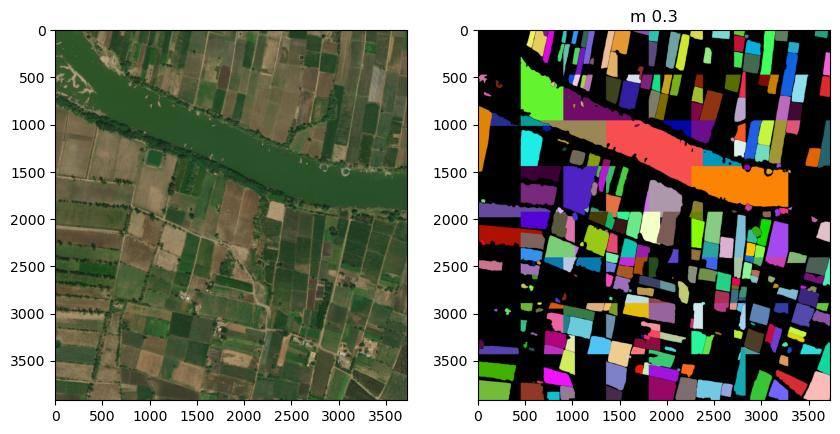

In [8]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 8,
        "spatial_overlap": 0.5,
        "mask_nms_thr": 0.3,
    },
)
run.monitor()

seg_raster_mask_thr_03 = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(basemap, {"mask_nms_thr 0.3": seg_raster_mask_thr_03}, geom)

Output()

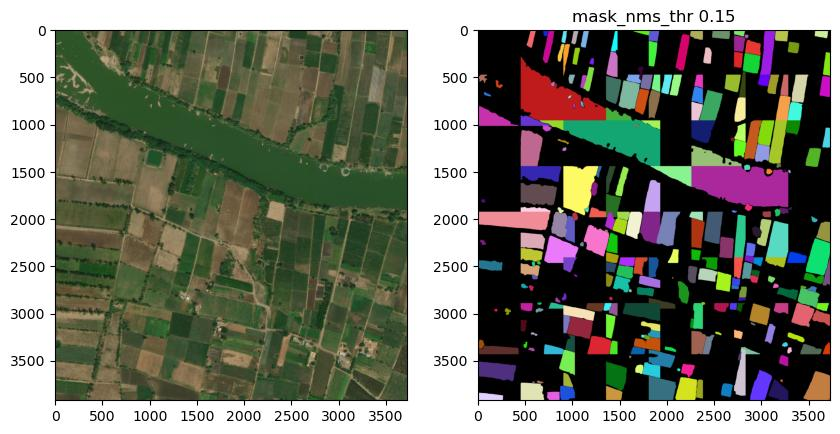

In [12]:
run = client.run(
    "farm_ai/segmentation/auto_segment_basemap",
    "SAM - Automatic Segmentation",
    geometry=geom,
    time_range=(datetime.now(), datetime.now()),
    parameters={
        "bingmaps_api_key": BING_MAPS_API_KEY,
        "basemap_zoom_level": 19,
        "points_per_side": 8,
        "spatial_overlap": 0.5,
        "mask_nms_thr": 0.15,
    },
)
run.monitor()

seg_raster_mask_thr_015 = color_autoseg_masks(run.output["segmentation_mask"][0])
plot_autoseg_masks(basemap, {"mask_nms_thr 0.15": seg_raster_mask_thr_015}, geom)

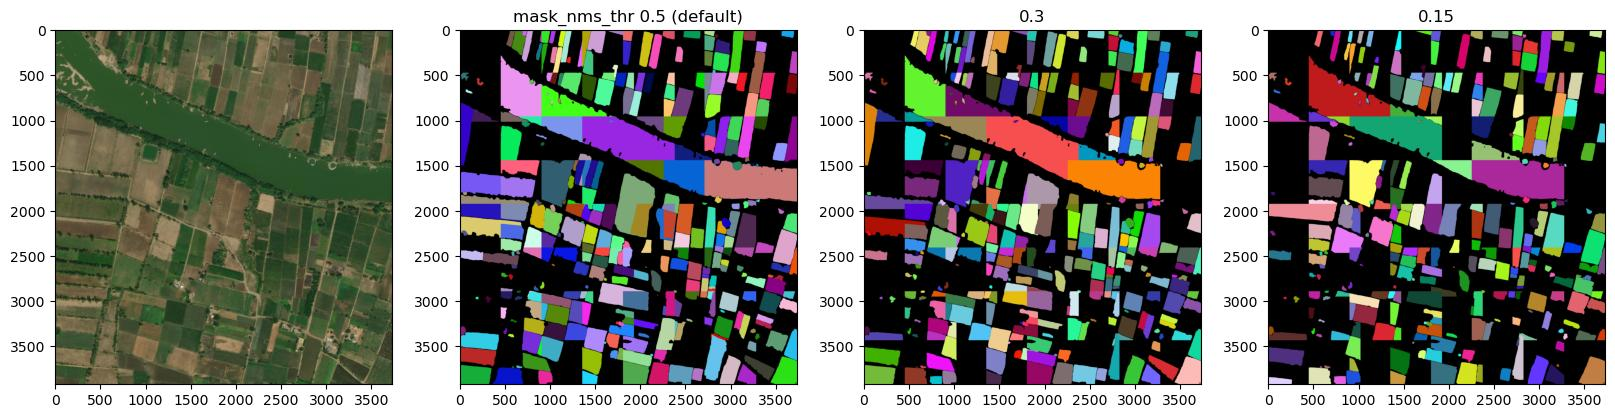

In [13]:
plot_autoseg_masks(
    basemap,
    {
        "mask_nms_thr 0.5 (default)": seg_raster_8pps_half_overlap,
        "0.3": seg_raster_mask_thr_03,
        "0.15": seg_raster_mask_thr_015,
    },
    geom,
    figsize=(20, 20),
)